In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "src"))
import numpy as np
import math
import wandb
from utils import Loss
from dataloader import load_fashion_mnist, load_mnist
from MLP import NeuralNet
from optimizer import GradientDescent


In [ ]:
sweep_config = {
    'method': 'random',
    'name': 'random_sweep',
}
metric = {
    'name': 'val_accuracy',
    'goal': 'maximize'   
}
sweep_config['metric'] = metric

parameters_dict = {
    "epochs": {'values': [5,10]},
    "num_layers": {'values': [3,4,5]},
    "hidden_size": {'values': [32,64, 128]},
    "weight_decay": {'values': [0, 0.0005, 0.5]},
    "learning_rate": {'values': [1e-3, 1e-4]},
    "optimizer": {'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']},
    "batch_size": {'values': [16, 32, 64]},
    "weight_init" : {'values': ['random', 'xavier']},
    "activation" : {'values': ['sigmoid', 'tanh', 'ReLU']},
    "loss" : {'values': ['cross_entropy']},
    "momentum" : {'values': [0.9]},
    "beta": {'values': [0.9]},
    "beta1": {'values': [0.9]},
    "beta2": {'values': [0.999]},
    "epsilon": {'values': [1e-8]},
    }

sweep_config['parameters'] = parameters_dict

In [4]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'parameters': {'activation': {'values': ['sigmoid', 'tanh', 'ReLU']},
                'batch_size': {'values': [16, 32, 64]},
                'beta': {'values': [0.9]},
                'beta1': {'values': [0.9]},
                'beta2': {'values': [0.999]},
                'epochs': {'values': [5, 10]},
                'epsilon': {'values': [1e-08]},
                'hidden_size': {'values': [32, 64, 128]},
                'learning_rate': {'values': [0.001, 0.0001]},
                'loss': {'values': ['cross_entropy']},
                'momentum': {'values': [0.9]},
                'num_layers': {'values': [3, 4, 5]},
                'optimizer': {'values': ['sgd',
                                         'momentum',
                                         'nag',
                                         'rmsprop',
                                         'adam',
                                         '

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DL_A1_Hyperparameter_Tuning")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: csun9e2g
Sweep URL: https://wandb.ai/deeplearn24/DLa1_random_sweep_25/sweeps/csun9e2g


In [6]:
def train_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        run_name = f"n{config.num_layers}_h{config.hidden_size}_wd{config.weight_decay}_lr{config.learning_rate}_{config.optimizer}_bs{config.batch_size}_{config.weight_init}_{config.activation}"
        wandb.run.name = run_name
        wandb.run.save()
        train, valid, test = load_fashion_mnist(config.batch_size)
        threshold = 1  # Clipping threshold for gradient clipping
        loss = Loss(loss_fn='cross_entropy')
        optimizer = GradientDescent(
            optimizer=config.optimizer,
            lr=config.learning_rate,
            clipping_threshold=threshold,
            momentum=config.momentum,
            beta=config.beta,
            beta1=config.beta1,
            beta2=config.beta2,
            epsilon=config.epsilon,
        )
        model = NeuralNet(
            input_size=784,
            hidden_size=config.hidden_size,
            output_size=10,
            n_hidden=config.num_layers,
            loss=loss,
            activation=[config.activation, "softmax"],
            weight_init=config.weight_init,
            weight_decay=config.weight_decay,
        )

        for epoch in range(config.epochs):
            i = 0
            batch_train_loss = []
            batch_valid_loss = []
            batch_train_accuracy = []
            batch_valid_accuracy = []

            for (x, y) in train:
                loss, accuracy = optimizer.optimize(model, x, y, i)
                batch_train_loss.append(loss)
                batch_train_accuracy.append(accuracy)

                i += 1
                wandb.log({"train/batch_loss": loss})

            for x_val, y_val in valid:
                valid_output, valid_loss, valid_accuracy = model(x_val, y_val)
                batch_valid_loss.append(valid_loss)
                batch_valid_accuracy.append(valid_accuracy)


            wandb.log({"epoch": epoch + 1, "train/loss": np.mean(batch_train_loss), "train/accuracy": np.mean(batch_train_accuracy), "val/loss": np.mean(batch_valid_loss), "val/accuracy": np.mean(batch_valid_accuracy)})
            print(
                f"Epoch: {epoch + 1}, Train Loss: {np.mean(batch_train_loss)}, Valid Loss: {np.mean(batch_valid_loss)}"
            )




wandb: Agent Starting Run: x31rmars with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
wandb: Currently logged in as: bt23s013 (deeplearn24) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


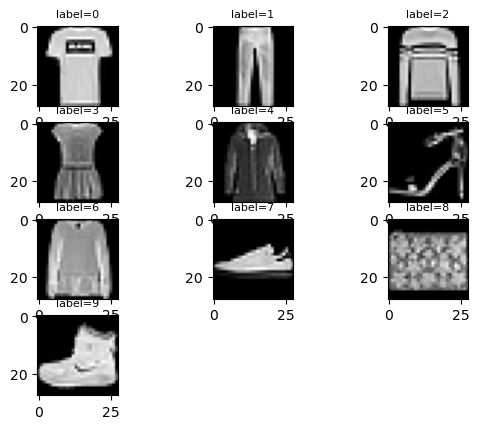

Epoch: 1, Train Loss: 8.485264508357377, Valid Loss: 1.7333327208740197
Epoch: 2, Train Loss: 1.4886995923688506, Valid Loss: 1.3370976298338668
Epoch: 3, Train Loss: 1.2391741131958556, Valid Loss: 1.1575156466473333
Epoch: 4, Train Loss: 1.2106163398340954, Valid Loss: 1.1503179050469037
Epoch: 5, Train Loss: 1.2010384359519524, Valid Loss: 1.3151926392677422
Epoch: 6, Train Loss: 1.1676518057909264, Valid Loss: 1.2685459086040616
Epoch: 7, Train Loss: 1.2331059138117308, Valid Loss: 1.2676083989362938
Epoch: 8, Train Loss: 1.260850892065361, Valid Loss: 1.3714023571138472
Epoch: 9, Train Loss: 1.2962314265473647, Valid Loss: 1.2860578867929953
Epoch: 10, Train Loss: 1.2919632686473301, Valid Loss: 1.5096239285613742


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▇▇███████
train/batch_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▁▁▁▁▁▁▁▁▁
val/accuracy,▁▅▆█▆▅▆▅█▇
val/loss,█▃▁▁▃▂▂▄▃▅
epoch,10
train/accuracy,0.79345
train/batch_loss,3.7759
train/loss,1.29196
val/accuracy,0.77128


wandb: Agent Starting Run: 7nw3a3fy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


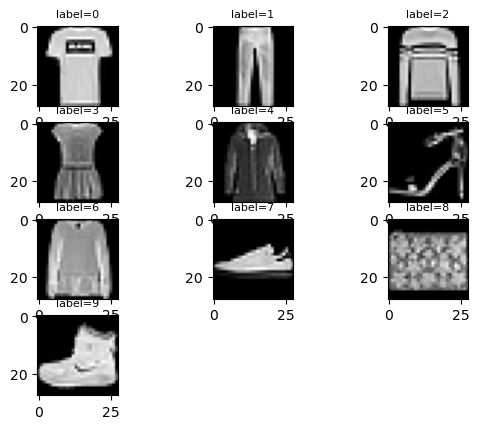

Epoch: 1, Train Loss: 6716.525682948741, Valid Loss: 22412.889909115285
Epoch: 2, Train Loss: 52949.83328226328, Valid Loss: 89065.88588285254
Epoch: 3, Train Loss: 127837.31626405074, Valid Loss: 155033.94362170767
Epoch: 4, Train Loss: 136764.1132462174, Valid Loss: 83234.4726266976
Epoch: 5, Train Loss: 41515.309993693714, Valid Loss: 13132.408904351483


epoch,▁▃▅▆█
train/accuracy,█▃▃▂▁
train/batch_loss,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▄▅▅▅▅▆▆▆▇▇▇██████▇▇▇▃▃▃▂▂
train/loss,▁▃██▃
val/accuracy,▁▁▁▁▁
val/loss,▁▅█▄▁
epoch,5
train/accuracy,0.09983
train/batch_loss,13142.36236
train/loss,41515.30999
val/accuracy,0.09167


wandb: Agent Starting Run: 1aolqn0u with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


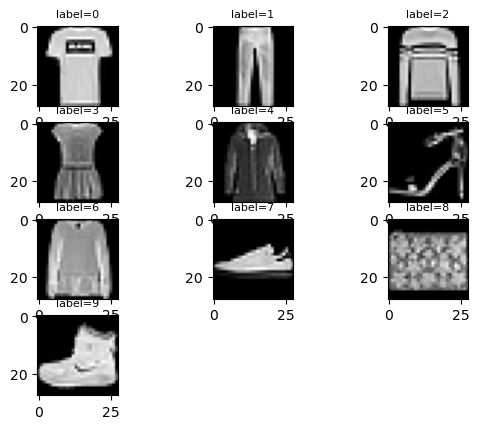

Epoch: 1, Train Loss: 8.570588116381078, Valid Loss: 5.772190387198354
Epoch: 2, Train Loss: 4.032977715344364, Valid Loss: 3.059861933387666
Epoch: 3, Train Loss: 2.576493628032391, Valid Loss: 2.190586640566831
Epoch: 4, Train Loss: 1.9074569426745172, Valid Loss: 1.6848379057839122
Epoch: 5, Train Loss: 1.57776984459312, Valid Loss: 1.5424270284307058
Epoch: 6, Train Loss: 1.375147969775435, Valid Loss: 1.3271931622127422
Epoch: 7, Train Loss: 1.2417953584572727, Valid Loss: 1.2047745804583208
Epoch: 8, Train Loss: 1.1324927528559803, Valid Loss: 1.163494385102748
Epoch: 9, Train Loss: 1.066585674702768, Valid Loss: 1.0141014995771958
Epoch: 10, Train Loss: 1.0125097837896873, Valid Loss: 1.0332963378787448


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▄▅▅▆▆▇▇██
train/batch_loss,██▅▄▅▂▂▂▃▃▃▂▂▂▁▁▂▃▃▁▁▁▁▂▂▂▁▁▁▂▁▁▁▂▁▂▂▁▂▁
train/loss,█▄▂▂▂▁▁▁▁▁
val/accuracy,▁▃▃▄▄▅▆▆██
val/loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train/accuracy,0.7363
train/batch_loss,0.44216
train/loss,1.01251
val/accuracy,0.73438


wandb: Agent Starting Run: iy7lsyax with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


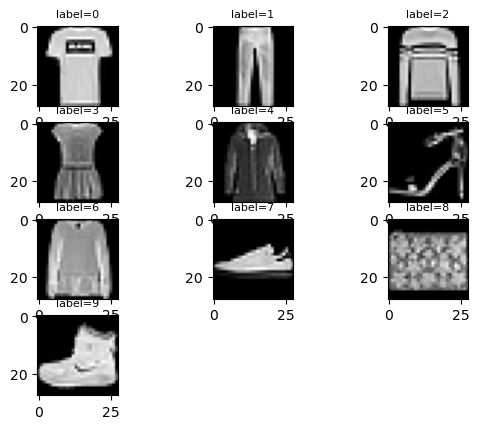

Epoch: 1, Train Loss: 2.5150113956559825, Valid Loss: 2.5987733808911684
Epoch: 2, Train Loss: 2.7204979645353515, Valid Loss: 2.9976129064833605
Epoch: 3, Train Loss: 3.3903794268997163, Valid Loss: 4.098123542564863
Epoch: 4, Train Loss: 5.020380521924855, Valid Loss: 6.549851098126219
Epoch: 5, Train Loss: 7.647558704235733, Valid Loss: 8.991209319633498


epoch,▁▃▅▆█
train/accuracy,▁█▅▁▁
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▆▆▆▇█
train/loss,▁▁▂▄█
val/accuracy,██▁▂▂
val/loss,▁▁▃▅█
epoch,5
train/accuracy,0.10932
train/batch_loss,8.98862
train/loss,7.64756
val/accuracy,0.10821


wandb: Agent Starting Run: zbxta8ws with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


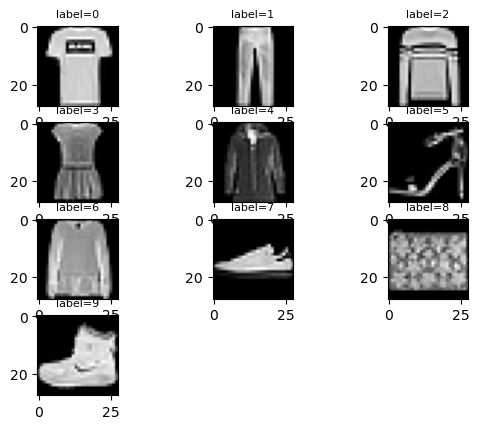

Epoch: 1, Train Loss: 1.5856139544629788, Valid Loss: 1.9706619834816785
Epoch: 2, Train Loss: 2.311166756721139, Valid Loss: 2.499129977207493
Epoch: 3, Train Loss: 3.0447826265067173, Valid Loss: 4.11998965981296
Epoch: 4, Train Loss: 7.357323073545694, Valid Loss: 11.477069544305557
Epoch: 5, Train Loss: 16.821562663338327, Valid Loss: 19.180008666167648


epoch,▁▃▅▆█
train/accuracy,█▅▄▁▁
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▅▅▆▇▇██
train/loss,▁▁▂▄█
val/accuracy,█▆▃▁▁
val/loss,▁▁▂▅█
epoch,5
train/accuracy,0.10052
train/batch_loss,19.21705
train/loss,16.82156
val/accuracy,0.09536


wandb: Agent Starting Run: dbruml4n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


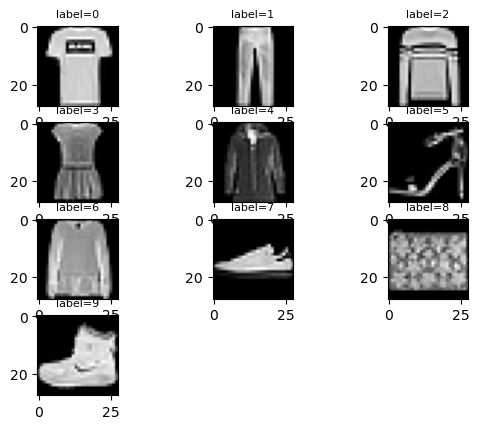

Epoch: 1, Train Loss: 1.2187721445225115, Valid Loss: 1.1485171871360713
Epoch: 2, Train Loss: 1.5124560016559965, Valid Loss: 2.242212050175557
Epoch: 3, Train Loss: 2.9481197887303554, Valid Loss: 4.0338406802543
Epoch: 4, Train Loss: 4.884540552854139, Valid Loss: 6.759921536243916
Epoch: 5, Train Loss: 9.88626485202249, Valid Loss: 11.922701601100233
Epoch: 6, Train Loss: 10.800717029386533, Valid Loss: 9.572311214307398
Epoch: 7, Train Loss: 10.073436578262006, Valid Loss: 11.284466177712916
Epoch: 8, Train Loss: 13.023328843577962, Valid Loss: 15.981207762369216
Epoch: 9, Train Loss: 18.661417686800903, Valid Loss: 21.384252116640607
Epoch: 10, Train Loss: 23.95547297331458, Valid Loss: 27.191546654373436


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,█▇▅▄▂▁▃▃▂▃
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▃▄▄▄▄▄▄▄▄▃▄▄▄▄▅▅▅▆▇▇▇█
train/loss,▁▁▂▂▄▄▄▅▆█
val/accuracy,█▅▄▃▁▁▄▃▂▃
val/loss,▁▁▂▃▄▃▄▅▆█
epoch,10
train/accuracy,0.23417
train/batch_loss,27.02968
train/loss,23.95547
val/accuracy,0.289


wandb: Agent Starting Run: 41tfa15c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


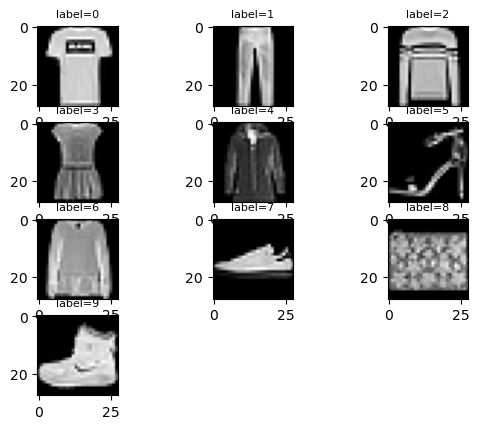

Epoch: 1, Train Loss: 28.038138457367257, Valid Loss: 38.717721217289856
Epoch: 2, Train Loss: 72.9315620824866, Valid Loss: 130.9542364703722
Epoch: 3, Train Loss: 211.3376931377782, Valid Loss: 349.9276350922681
Epoch: 4, Train Loss: 521.424692158324, Valid Loss: 788.1978488054125
Epoch: 5, Train Loss: 1019.7575083616495, Valid Loss: 1336.5917875528862


epoch,▁▃▅▆█
train/accuracy,▅▆█▁▁
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇█
train/loss,▁▁▂▄█
val/accuracy,▇█▁▁▁
val/loss,▁▁▃▅█
epoch,5
train/accuracy,0.09917
train/batch_loss,1335.99716
train/loss,1019.75751
val/accuracy,0.0989


wandb: Agent Starting Run: umubpzyy with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


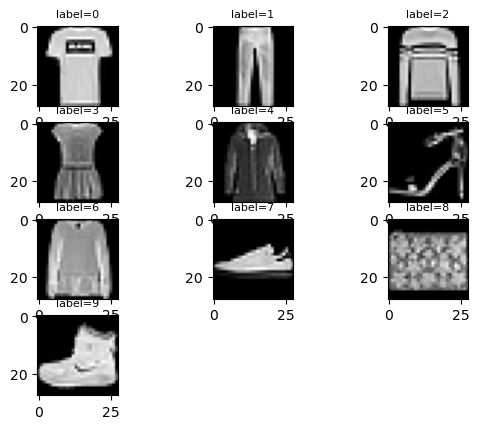

Epoch: 1, Train Loss: 5026.976613918217, Valid Loss: 3037.460656682856
Epoch: 2, Train Loss: 1998.0594236552859, Valid Loss: 1086.6789029583192
Epoch: 3, Train Loss: 583.3184603361101, Valid Loss: 268.9295016658185
Epoch: 4, Train Loss: 151.76810814818816, Valid Loss: 79.67474605733875
Epoch: 5, Train Loss: 52.631857873950366, Valid Loss: 35.47686685134704


epoch,▁▃▅▆█
train/accuracy,▂▁▄▇█
train/batch_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▂▁▁
val/accuracy,▄▁▆██
val/loss,█▃▂▁▁
epoch,5
train/accuracy,0.8158
train/batch_loss,35.63468
train/loss,52.63186
val/accuracy,0.82713


wandb: Agent Starting Run: 32zk6ysn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


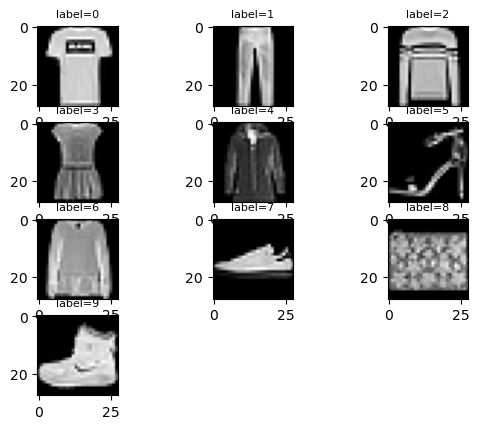

Epoch: 1, Train Loss: 1.8660002716740953, Valid Loss: 2.549830286568215
Epoch: 2, Train Loss: 2.2356085334106814, Valid Loss: 2.2528253935817415
Epoch: 3, Train Loss: 2.0430582534992867, Valid Loss: 2.24284097907834
Epoch: 4, Train Loss: 2.186424084129612, Valid Loss: 2.2614520422363436
Epoch: 5, Train Loss: 2.188522807155699, Valid Loss: 2.1706012052821984


epoch,▁▃▅▆█
train/accuracy,█▁▅▂▂
train/batch_loss,▁▂▃▄▅▅▆█▆▇▆▇▇▇▅▅▅▅▅▅▅▆▆▅▆▆▇▆▇▆▆▆▆▆▆▆▆▆▇▅
train/loss,▁█▄▇▇
val/accuracy,▁▇▆▅█
val/loss,█▃▂▃▁
epoch,5
train/accuracy,0.17976
train/batch_loss,2.07344
train/loss,2.18852
val/accuracy,0.1906


wandb: Agent Starting Run: y4tiows5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


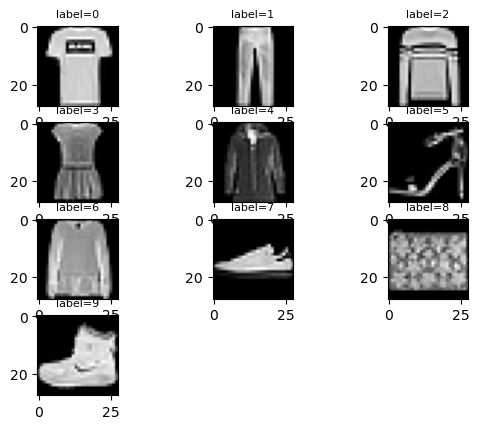

Epoch: 1, Train Loss: 23620.61397319706, Valid Loss: 33755.10689736617
Epoch: 2, Train Loss: 47431.5621587621, Valid Loss: 58416.39974270195
Epoch: 3, Train Loss: 98968.29868495051, Valid Loss: 137727.8006650034
Epoch: 4, Train Loss: 231084.09567658085, Valid Loss: 266242.2707214764
Epoch: 5, Train Loss: 294118.4952889139, Valid Loss: 333767.8040358822


epoch,▁▃▅▆█
train/accuracy,▄█▂▂▁
train/batch_loss,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
train/loss,▁▂▃▆█
val/accuracy,██▆▂▁
val/loss,▁▂▃▆█
epoch,5
train/accuracy,0.13844
train/batch_loss,333663.96901
train/loss,294118.49529
val/accuracy,0.11517


wandb: Agent Starting Run: wmqv5xkw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


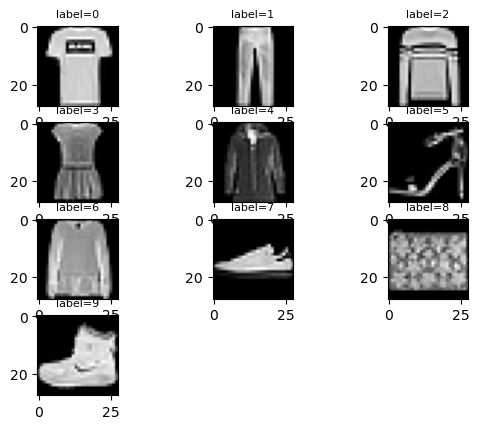

Epoch: 1, Train Loss: 9.68198782089408, Valid Loss: 7.78456313629128
Epoch: 2, Train Loss: 7.568473874267659, Valid Loss: 7.6326570357258054
Epoch: 3, Train Loss: 7.033778670317916, Valid Loss: 7.513360630355321
Epoch: 4, Train Loss: 6.5662710439565775, Valid Loss: 6.779207489761056
Epoch: 5, Train Loss: 6.23331705983317, Valid Loss: 7.899086479215585
Epoch: 6, Train Loss: 5.98302646603207, Valid Loss: 5.904885447318905
Epoch: 7, Train Loss: 5.725190729575747, Valid Loss: 5.528621735728784
Epoch: 8, Train Loss: 5.5686147654908, Valid Loss: 5.650938345167504
Epoch: 9, Train Loss: 5.420308432417006, Valid Loss: 5.159863760676772
Epoch: 10, Train Loss: 5.229458007413179, Valid Loss: 4.889440332630838


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▅▆▇▇▇████
train/batch_loss,▅▇▆▇▆█▄▅▇▄▇▇▆▄▄▅▅▄▅▇▂▂▇▅▄▅▄▅▄▃▅▅▄▃▃▅▄▃▁▂
train/loss,█▅▄▃▃▂▂▂▁▁
val/accuracy,▃▃▃▄▁▆▇▇██
val/loss,█▇▇▅█▃▂▃▂▁
epoch,10
train/accuracy,0.71467
train/batch_loss,8.58862
train/loss,5.22946
val/accuracy,0.72252


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: suyp4ls5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


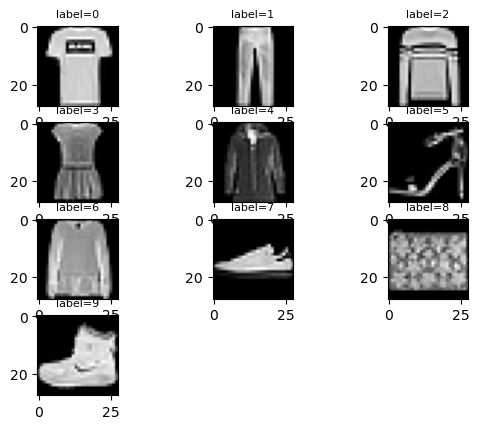

Epoch: 1, Train Loss: 4.551900710501362, Valid Loss: 2.358961230432883
Epoch: 2, Train Loss: 2.338252280171903, Valid Loss: 2.465335467310079
Epoch: 3, Train Loss: 2.4217076579870223, Valid Loss: 2.484158568975394
Epoch: 4, Train Loss: 2.394117010712616, Valid Loss: 2.4572221681622755
Epoch: 5, Train Loss: 2.3913788454392884, Valid Loss: 2.44962114782391


epoch,▁▃▅▆█
train/accuracy,█▇▁▁▁
train/batch_loss,█▅▅▃▃▁▁▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▁▁▁▁
val/accuracy,█▁▁▁▁
val/loss,▁▇█▆▆
epoch,5
train/accuracy,0.09809
train/batch_loss,2.31931
train/loss,2.39138
val/accuracy,0.10167


wandb: Agent Starting Run: mj42k8fs with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


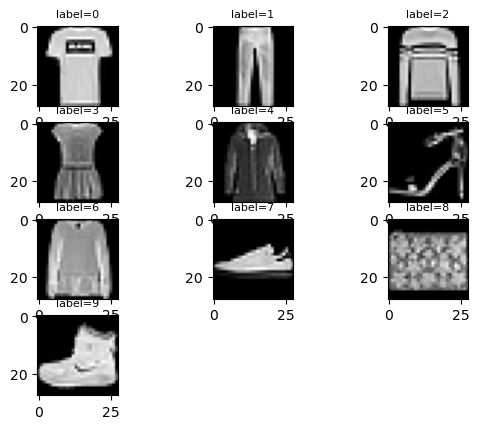

Epoch: 1, Train Loss: 0.7748085951234099, Valid Loss: 0.7075918258765864
Epoch: 2, Train Loss: 0.9039111678767328, Valid Loss: 1.0745483880585533
Epoch: 3, Train Loss: 1.0650690388609276, Valid Loss: 0.8618715559855434
Epoch: 4, Train Loss: 1.0837198122587064, Valid Loss: 1.1801005252375818
Epoch: 5, Train Loss: 1.0942966967021515, Valid Loss: 1.0491342158442691


epoch,▁▃▅▆█
train/accuracy,▁████
train/batch_loss,█▃▃▃▁▂▂▄▄▅▂▄▃▇▃▃▇▃▄▅▄▃▄▅█▄▂▅▃▄▄▂▃▇▄▆▃█▂▇
train/loss,▁▄▇██
val/accuracy,▆▁█▂▆
val/loss,▁▆▃█▆
epoch,5
train/accuracy,0.79126
train/batch_loss,1.44776
train/loss,1.0943
val/accuracy,0.81477


wandb: Agent Starting Run: qpy7fvpt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


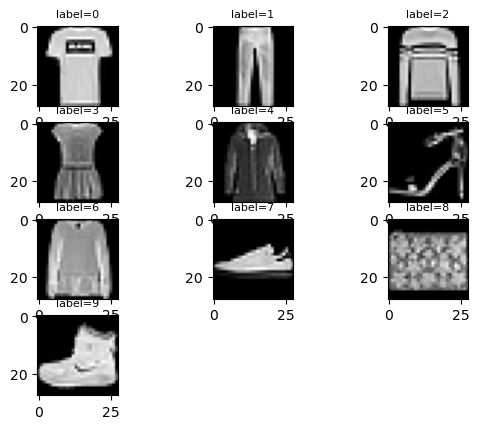

Epoch: 1, Train Loss: 14.197974606176057, Valid Loss: 12.381637960128343
Epoch: 2, Train Loss: 12.453617519550276, Valid Loss: 13.520086441086663
Epoch: 3, Train Loss: 12.466433123644821, Valid Loss: 13.44874327752546
Epoch: 4, Train Loss: 12.21644975635011, Valid Loss: 11.807886509939102
Epoch: 5, Train Loss: 12.181033693725878, Valid Loss: 13.385341057612846
Epoch: 6, Train Loss: 12.978308176830055, Valid Loss: 12.77169788204737
Epoch: 7, Train Loss: 13.50374572873761, Valid Loss: 13.652683748360074
Epoch: 8, Train Loss: 15.328794728421451, Valid Loss: 18.044531414486595
Epoch: 9, Train Loss: 17.75342318677491, Valid Loss: 17.628378997515767
Epoch: 10, Train Loss: 17.352867105964894, Valid Loss: 17.30406844381809


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▃▃▂▁▄▄▃▆█
train/batch_loss,▇█▄▂▆▁▃▄▁▅▂▃▁▃▂▃▃▂▂▄▅▄▄▃▄▃▆▅▇▆███▇▇▇▇▇▇▇
train/loss,▄▁▁▁▁▂▃▅█▇
val/accuracy,▄▂▄▁▂▃▁▁█▁
val/loss,▂▃▃▁▃▂▃██▇
epoch,10
train/accuracy,0.19498
train/batch_loss,17.29487
train/loss,17.35287
val/accuracy,0.11083


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8dcq16p0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


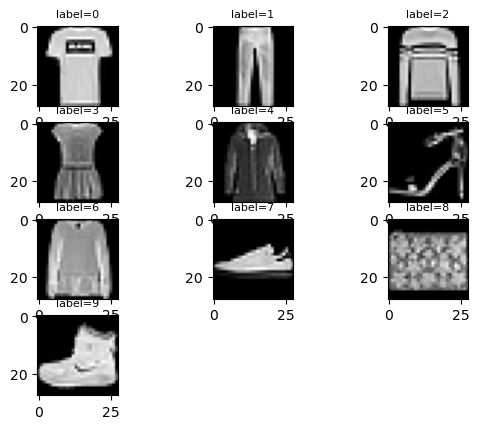

Epoch: 1, Train Loss: 2.933378565195566, Valid Loss: 4.225755298687382
Epoch: 2, Train Loss: 12.0616222760204, Valid Loss: 18.14926833655011
Epoch: 3, Train Loss: 17.973132425297354, Valid Loss: 21.261236363524336
Epoch: 4, Train Loss: 30.664877355358144, Valid Loss: 31.24357955608848
Epoch: 5, Train Loss: 37.752235572049415, Valid Loss: 42.40250375768895


epoch,▁▃▅▆█
train/accuracy,█▅▄▂▁
train/batch_loss,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▄▄▄▄▅▆▇▇███▇▇▇▇▇▇
train/loss,▁▃▄▇█
val/accuracy,█▅▃▁▃
val/loss,▁▄▄▆█
epoch,5
train/accuracy,0.1235
train/batch_loss,42.5103
train/loss,37.75224
val/accuracy,0.18767


wandb: Agent Starting Run: cfwd36v4 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


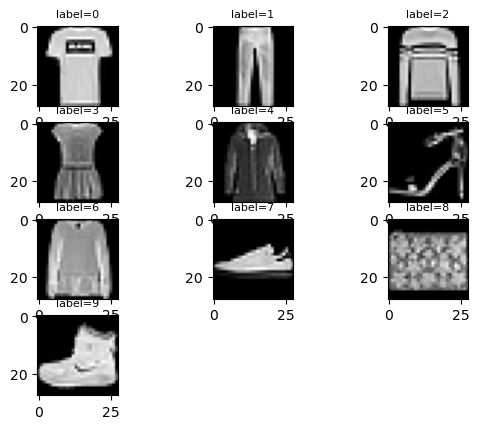

Epoch: 1, Train Loss: 38.66086106623933, Valid Loss: 26.900896578666043
Epoch: 2, Train Loss: 22.516421942272817, Valid Loss: 19.141711530123516
Epoch: 3, Train Loss: 17.19435810184366, Valid Loss: 16.373496582976845
Epoch: 4, Train Loss: 15.160804511111436, Valid Loss: 15.557025625112606
Epoch: 5, Train Loss: 14.25316312730346, Valid Loss: 14.881876973101042


epoch,▁▃▅▆█
train/accuracy,▁██▇▅
train/batch_loss,██▆▆▅▅▄▄▄▄▃▂▂▂▂▁▃▂▃▂▃▁▂▂▁▂▂▁▂▁▁▁▃▁▁▂▁▂▂▂
train/loss,█▃▂▁▁
val/accuracy,██▇▄▁
val/loss,█▃▂▁▁
epoch,5
train/accuracy,0.65902
train/batch_loss,17.90422
train/loss,14.25316
val/accuracy,0.5975


wandb: Agent Starting Run: s2rkpryo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


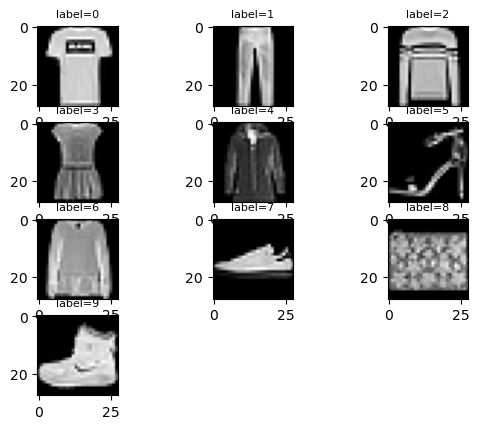

Epoch: 1, Train Loss: 2.432408944064704, Valid Loss: 2.3685054025644554
Epoch: 2, Train Loss: 2.379304633961099, Valid Loss: 2.3960257006072396
Epoch: 3, Train Loss: 2.424382593417577, Valid Loss: 2.4579450845170703
Epoch: 4, Train Loss: 2.5021184240663827, Valid Loss: 2.5523065132423484
Epoch: 5, Train Loss: 2.612828443399579, Valid Loss: 2.679747757432876
Epoch: 6, Train Loss: 2.756683618304381, Valid Loss: 2.840739131108413
Epoch: 7, Train Loss: 2.93515350881466, Valid Loss: 3.037018290983338
Epoch: 8, Train Loss: 3.1489890878916156, Valid Loss: 3.2701071328524622
Epoch: 9, Train Loss: 3.4036166878121508, Valid Loss: 3.547464000653142
Epoch: 10, Train Loss: 3.702672110321217, Valid Loss: 3.8687672980469805


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▇█▁▄▃▁▃▇▇█
train/batch_loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▇▇▇▇█
train/loss,▁▁▁▂▂▃▄▅▆█
val/accuracy,█▄▄▄▄▁▄▄▄▄
val/loss,▁▁▁▂▂▃▄▅▇█
epoch,10
train/accuracy,0.0998
train/batch_loss,3.86698
train/loss,3.70267
val/accuracy,0.10106


wandb: Agent Starting Run: e80e4uqg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


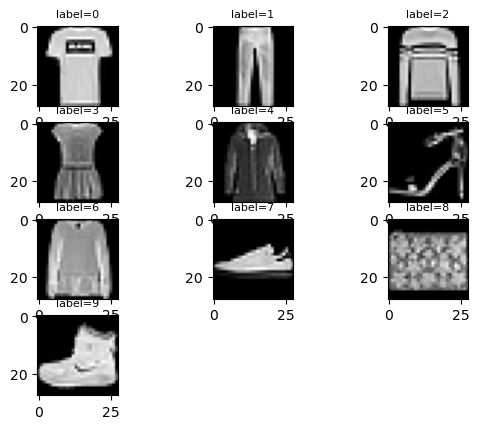

Epoch: 1, Train Loss: 2.5901335530121146, Valid Loss: 2.314602637031761
Epoch: 2, Train Loss: 2.327168298661301, Valid Loss: 2.321646788910815
Epoch: 3, Train Loss: 2.3270784252907393, Valid Loss: 2.3157304513934185
Epoch: 4, Train Loss: 2.32527814960619, Valid Loss: 2.321472844179331
Epoch: 5, Train Loss: 2.324988508456811, Valid Loss: 2.3232789524731623


epoch,▁▃▅▆█
train/accuracy,▇█▁▂▃
train/batch_loss,▁▅▄▃▄▂▄▃▅▇▃█▅▆▄▂▄▃▄▃▆▅▆▃▃▄▂▂▇▂▆▅▇▄▃▄▄▇▆▃
train/loss,█▁▁▁▁
val/accuracy,▁█▁▁▁
val/loss,▁▇▂▇█
epoch,5
train/accuracy,0.10044
train/batch_loss,2.355
train/loss,2.32499
val/accuracy,0.093


wandb: Agent Starting Run: xhf8atft with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


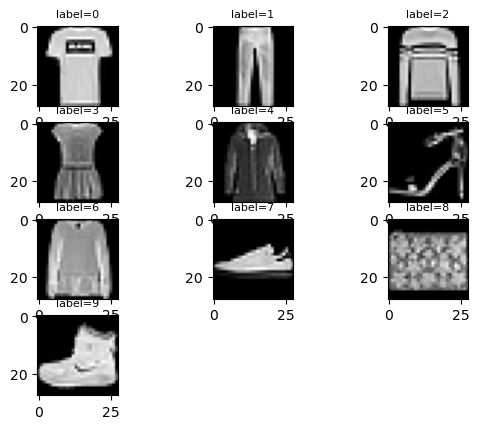

Epoch: 1, Train Loss: 36673.219399969916, Valid Loss: 43430.57090669172
Epoch: 2, Train Loss: 56398.6526637835, Valid Loss: 63178.58140174524
Epoch: 3, Train Loss: 63296.082072311896, Valid Loss: 65767.24723816839
Epoch: 4, Train Loss: 65873.2947717133, Valid Loss: 66567.66000807552
Epoch: 5, Train Loss: 66444.62310273023, Valid Loss: 70252.69470514238


epoch,▁▃▅▆█
train/accuracy,▁▄▇▇█
train/batch_loss,▁▁▁▂▂▁▁▂▃▃▃▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█
train/loss,▁▆▇██
val/accuracy,▁▄▆▆█
val/loss,▁▆▇▇█
epoch,5
train/accuracy,0.47207
train/batch_loss,70244.52863
train/loss,66444.6231
val/accuracy,0.46467


wandb: Agent Starting Run: 3ouw16vz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


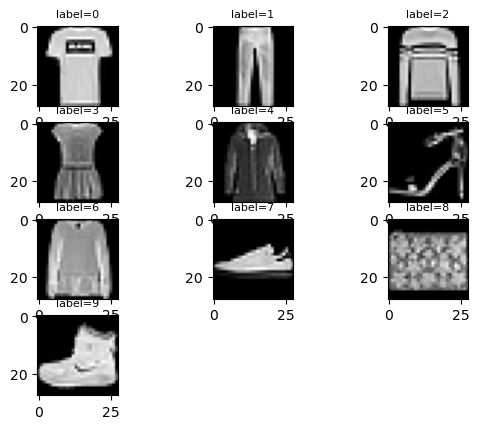

Epoch: 1, Train Loss: 10.234951569802364, Valid Loss: 6.569400442135766
Epoch: 2, Train Loss: 4.180817630245063, Valid Loss: 2.537318459088878
Epoch: 3, Train Loss: 2.371752929248715, Valid Loss: 2.2706539425773618
Epoch: 4, Train Loss: 2.2991982929790264, Valid Loss: 2.3095262727476933
Epoch: 5, Train Loss: 2.2955207706934964, Valid Loss: 2.2567859492263165


epoch,▁▃▅▆█
train/accuracy,▁▂█▄▃
train/batch_loss,▆▆▆█████▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▃▁▁▁
val/accuracy,▁▄▅▁█
val/loss,█▁▁▁▁
epoch,5
train/accuracy,0.10249
train/batch_loss,2.24677
train/loss,2.29552
val/accuracy,0.17204


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2cbqkudp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


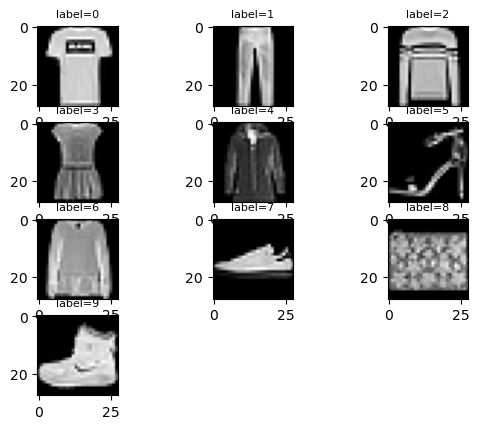

Epoch: 1, Train Loss: 492.45097956673203, Valid Loss: 1431.8042299400533
Epoch: 2, Train Loss: 6785.4147816214, Valid Loss: 7168.597396819228
Epoch: 3, Train Loss: 5799.338298616497, Valid Loss: 7513.975912944441
Epoch: 4, Train Loss: 7514.224907672023, Valid Loss: 7600.15733611593
Epoch: 5, Train Loss: 10780.507702045172, Valid Loss: 7211.326354856117
Epoch: 6, Train Loss: 9357.603819177417, Valid Loss: 16916.73543907133
Epoch: 7, Train Loss: 21447.598857889254, Valid Loss: 24489.56273752874
Epoch: 8, Train Loss: 27009.743522398632, Valid Loss: 29693.878805008182
Epoch: 9, Train Loss: 28713.22494170256, Valid Loss: 22956.47323607681
Epoch: 10, Train Loss: 21142.023162289297, Valid Loss: 26903.692086593106


epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▄▄▁▂█▃▄▃▃▂
train/batch_loss,▁▁▁▁▁▂▃▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▃▃▃▃▄▆▇▇█████▆▆▆▅▆
train/loss,▁▃▂▃▄▃▆██▆
val/accuracy,▂▆█▅▂▂▂▁▅▅
val/loss,▁▂▃▃▂▅▇█▆▇
epoch,10
train/accuracy,0.09944
train/batch_loss,26866.31813
train/loss,21142.02316
val/accuracy,0.10001


wandb: Agent Starting Run: dk3abooe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


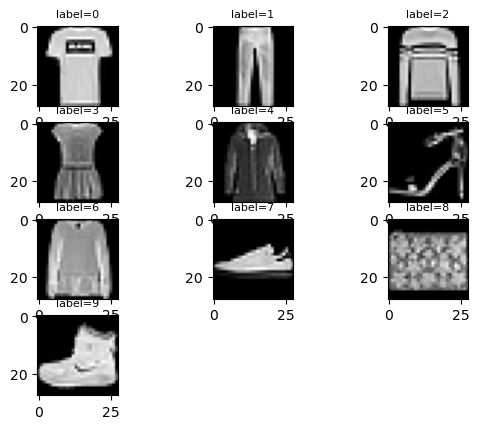

Epoch: 1, Train Loss: 1.2591769491227773, Valid Loss: 1.0078883818844877
Epoch: 2, Train Loss: 1.0118897675288632, Valid Loss: 1.0376195443471414
Epoch: 3, Train Loss: 1.073460416559324, Valid Loss: 1.239228251958332
Epoch: 4, Train Loss: 1.3598120366998865, Valid Loss: 1.3456814449152141
Epoch: 5, Train Loss: 1.3803694080530688, Valid Loss: 1.4430004240134338


epoch,▁▃▅▆█
train/accuracy,▃█▅▁▄
train/batch_loss,▆▄▄▃▅▃▁▂▃▅▂▃▄▂▃▃▄▅▃▃▄▃▇▄▇▆▅▃▅▅▆▇▄▄▄▅▆▆▆█
train/loss,▆▁▂██
val/accuracy,█▅▁▄▂
val/loss,▁▁▅▆█
epoch,5
train/accuracy,0.66194
train/batch_loss,1.67715
train/loss,1.38037
val/accuracy,0.64233


wandb: Agent Starting Run: zt5huwpv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


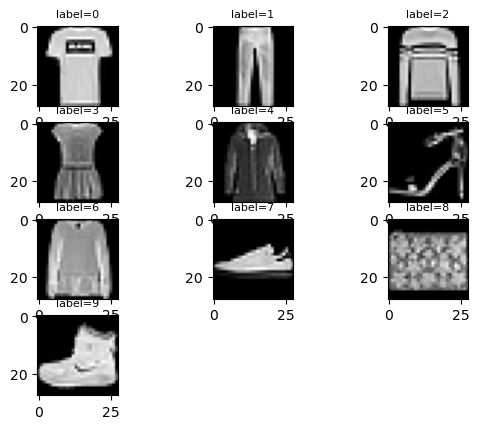

Epoch: 1, Train Loss: 165.79630402439602, Valid Loss: 539.9432324802242
Epoch: 2, Train Loss: 2351.0662410178165, Valid Loss: 4281.4713607383255
Epoch: 3, Train Loss: 5276.921763871704, Valid Loss: 8382.267667260892
Epoch: 4, Train Loss: 8663.499058995507, Valid Loss: 10050.589691962394
Epoch: 5, Train Loss: 12630.811573605177, Valid Loss: 17648.953134731946


epoch,▁▃▅▆█
train/accuracy,█▂▁▂▅
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇█
train/loss,▁▂▄▆█
val/accuracy,▆▁█▇▇
val/loss,▁▃▄▅█
epoch,5
train/accuracy,0.29608
train/batch_loss,17649.28463
train/loss,12630.81157
val/accuracy,0.19919


wandb: Agent Starting Run: 7zmn2kvx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


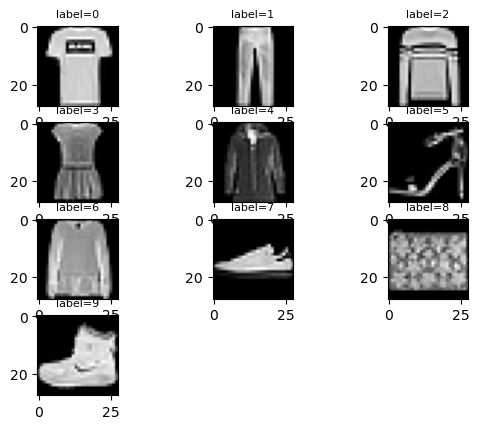

Epoch: 1, Train Loss: 2.5896843150153095, Valid Loss: 2.7736551410322954
Epoch: 2, Train Loss: 3.0200789995197357, Valid Loss: 3.5454890947555486
Epoch: 3, Train Loss: 5.00160625641214, Valid Loss: 6.844391104873921
Epoch: 4, Train Loss: 8.908186614305713, Valid Loss: 10.986737285331335
Epoch: 5, Train Loss: 15.39387263913275, Valid Loss: 20.65084526347461


epoch,▁▃▅▆█
train/accuracy,▂▅▁▁█
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▆▇█
train/loss,▁▁▂▄█
val/accuracy,▄▇▃█▁
val/loss,▁▁▃▄█
epoch,5
train/accuracy,0.1232
train/batch_loss,20.66545
train/loss,15.39387
val/accuracy,0.09009


wandb: Agent Starting Run: 1qk4l9y3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


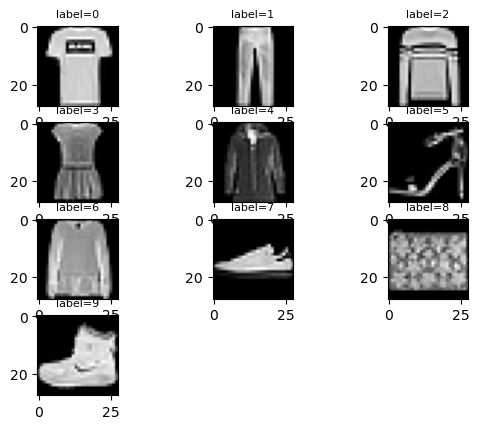

Epoch: 1, Train Loss: 52.64147290318049, Valid Loss: 106.81182334085453
Epoch: 2, Train Loss: 157.18299743576114, Valid Loss: 203.11395713096218
Epoch: 3, Train Loss: 211.19169936264902, Valid Loss: 248.76639217578628
Epoch: 4, Train Loss: 319.9276604684211, Valid Loss: 450.99920713353316
Epoch: 5, Train Loss: 686.1503662460689, Valid Loss: 1122.661894369266


epoch,▁▃▅▆█
train/accuracy,▆█▆▃▁
train/batch_loss,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▅▅█
train/loss,▁▂▃▄█
val/accuracy,██▄▁▁
val/loss,▁▂▂▃█
epoch,5
train/accuracy,0.09796
train/batch_loss,1120.98177
train/loss,686.15037
val/accuracy,0.10234


In [7]:
wandb.agent(sweep_id, train_wandb, count=25)